## Environment setup

In [ ]:

import cv2
import os
import locale
locale.getpreferredencoding = lambda: "UTF-8"
from IPython.display import Image
import numpy as np
import torchvision.transforms as transforms
from PIL import Image, ImageOps
import cv2
import colorsys
import random
import numpy as np
import os, random, tensorflow as tf

In [ ]:

seed_value=1234
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
os.environ['PYTHONHASHSEED'] = str(seed_value)

### Check GPU availability

**NOTE:** **YOLOv12 leverages FlashAttention to speed up attention-based computations, but this feature requires an Nvidia GPU built on the Ampere architecture or newer—for example, GPUs like the RTX 3090, RTX 3080, or even the Nvidia L4 meet this requirement.**

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [4]:
!nvidia-smi

Sun Mar  9 16:20:32 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 566.36                 Driver Version: 566.36         CUDA Version: 12.7     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   57C    P3              8W /   36W |      19MiB /   6141MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!pip install git+https://github.com/sunsmarterjie/yolov12.git
!pip install supervision
!pip install flash-attn --no-cache-dir
!pip install huggingface_hub
import cv2
from ultralytics import YOLO
import supervision as sv

  Cloning https://github.com/sunsmarterjie/yolov12.git to c:\users\manus\appdata\local\temp\pip-req-build-fkizoecv
  Resolved https://github.com/sunsmarterjie/yolov12.git to commit 4856283cae896b266fd5be56d99b841bc88e9b29
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'


  Running command git clone --filter=blob:none --quiet https://github.com/sunsmarterjie/yolov12.git 'C:\Users\Manus\AppData\Local\Temp\pip-req-build-fkizoecv'


     ---------------------------------------- 0.0/6.0 MB ? eta -:--:--
     ---------------------------------------- 6.0/6.0 MB 73.4 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [21 lines of output]
      
      
      torch.__version__  = 2.5.1
      
      
      C:\Users\Manus\AppData\Local\Temp\pip-install-rnkgv4s3\flash-attn_0a7ef5f7fd3f4a2eb5ba84476e5d07aa\setup.py:106: UserWarning: flash_attn was requested, but nvcc was not found.  Are you sure your environment has nvcc available?  If you're installing within a container from https://hub.docker.com/r/pytorch/pytorch, only images whose names contain 'devel' will provide nvcc.
        warnings.warn(
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\Manus\AppData\Local\Temp\pip-install-rnkgv4s3\flash-attn_0a7ef5f7fd3f4a2eb5ba84476e5d07aa\setup.py", line 198, in <module>
          CUDAExtension(
        File "c:\Users\Manus\anaconda3\Lib\site-packages\torch\utils\cpp_exten

FlashAttention is not available on this device. Using scaled_dot_product_attention instead.


In [57]:
current_path = os.getcwd()
HOME = os.path.abspath(os.path.join(current_path, '..'))
print(f"HOME path: {HOME}")

HOME path: c:\Manus\DL_project\project


## Run inference

In the example, we're using the `yolov12l.pt` model, but you can experiment with different model sizes by simply swapping out the model name during initialization. Options include `yolov12n.pt`, `yolov12s.pt`, `yolov12m.pt`, `yolov12l.pt`, and `yolov12x.pt`.

In [7]:
dataset_location = f"{HOME}\\dataset_plates"

In [8]:
print(dataset_location)

c:\Manus\DL_project\project\dataset_plates


In [ ]:
# Define the file path
file_path = os.path.join(dataset_location, "data.yaml")

In [10]:
with open(file_path, "r") as f:
    print(f.read())


train: ../train/images
val: ../valid/images
test: ../test/images

nc: 1
names: ['plates']




## Fine-tune YOLOv12 model

We are now ready to fine-tune our YOLOv12 model. In the code below, we initialize the model using a starting checkpoint—here, we use `yolov12s.yaml`, but you can replace it with any other model (e.g., `yolov12n.pt`, `yolov12m.pt`, `yolov12l.pt`, or `yolov12x.pt`) based on your preference. We set the training to run for 100 epochs in this example; however, you should adjust the number of epochs along with other hyperparameters such as batch size, image size, and augmentation settings (scale, mosaic, mixup, and copy-paste) based on your hardware capabilities and dataset size.

**Note:** **Note that after training, you might encounter a `TypeError: argument of type 'PosixPath' is not iterable error` — this is a known issue, but your model weights will still be saved, so you can safely proceed to running inference.**

In [ ]:
model = YOLO('yolov12n.yaml')

results = model.train(data=f'{dataset_location}/data.yaml',epochs=20,imgsz=640,batch=8)  # ลด batch size


New https://pypi.org/project/ultralytics/8.3.86 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.63  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
engine\trainer: task=detect, mode=train, model=yolov12n.yaml, data=c:\Manus\DL_project\project\dataset_plates/data.yaml, epochs=20, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks

train: Scanning C:\Manus\DL_project\project\dataset_plates\train\labels.cache... 171 images, 6 backgrounds, 0 corrupt: 100%|██████████| 171/171 [00:00<?, ?it/s]

WARNING  Box and segment counts should be equal, but got len(segments) = 339, len(boxes) = 1431. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.



val: Scanning C:\Manus\DL_project\project\dataset_plates\valid\labels.cache... 13 images, 0 backgrounds, 0 corrupt: 100%|██████████| 13/13 [00:00<?, ?it/s]

WARNING  Box and segment counts should be equal, but got len(segments) = 14, len(boxes) = 124. To resolve this only boxes will be used and all segments will be removed. To avoid this please supply either a detect or segment dataset, not a detect-segment mixed dataset.


Plotting labels to runs\detect\train\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/22 [00:00<?, ?it/s]UserWarning: Memory Efficient attention defaults to a non-deterministic algorithm. To explicitly enable determinism call torch.use_deterministic_algorithms(True, warn_only=False). (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\attention_backward.cu:657.)
       1/20      1.53G      6.196      4.928      4.515         95        640: 100%|██████████| 22/22 [00:05<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  4.80it/s]

                   all         13        124          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.51G      5.326      3.801      4.057         38        640: 100%|██████████| 22/22 [00:03<00:00,  7.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.88it/s]


                   all         13        124          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.49G      4.591       3.08      3.543         78        640: 100%|██████████| 22/22 [00:03<00:00,  7.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.34it/s]

                   all         13        124          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.42G      4.035      2.564      3.184         50        640: 100%|██████████| 22/22 [00:02<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.75it/s]

                   all         13        124          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.58G      3.681      2.233      2.908         66        640: 100%|██████████| 22/22 [00:02<00:00,  7.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.23it/s]


                   all         13        124          0          0          0          0

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.49G      3.467      2.085       2.74         50        640: 100%|██████████| 22/22 [00:02<00:00,  7.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.87it/s]

                   all         13        124          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.51G      3.368      1.973      2.666         44        640: 100%|██████████| 22/22 [00:02<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.26it/s]

                   all         13        124      0.291      0.339      0.186     0.0352



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.53G      3.175      1.866      2.545         23        640: 100%|██████████| 22/22 [00:02<00:00,  7.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.43it/s]

                   all         13        124       0.43      0.516      0.365     0.0906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.57G      3.074      1.764      2.565         78        640: 100%|██████████| 22/22 [00:02<00:00,  7.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.60it/s]

                   all         13        124      0.317      0.444      0.248       0.05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.48G      2.983      1.753      2.433         65        640: 100%|██████████| 22/22 [00:02<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.69it/s]


                   all         13        124      0.559      0.516      0.516      0.186
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.39G      2.647      1.687      2.137         13        640: 100%|██████████| 22/22 [00:03<00:00,  6.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  7.84it/s]

                   all         13        124      0.561      0.548      0.546       0.15



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.38G       2.64       1.68      2.094         41        640: 100%|██████████| 22/22 [00:02<00:00,  7.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.14it/s]

                   all         13        124      0.524      0.637      0.554      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.38G       2.48      1.641       2.07         23        640: 100%|██████████| 22/22 [00:03<00:00,  6.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.60it/s]

                   all         13        124      0.631      0.653      0.654      0.225



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.37G      2.524      1.648      2.099         33        640: 100%|██████████| 22/22 [00:02<00:00,  7.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.08it/s]

                   all         13        124      0.591      0.702      0.654      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.38G      2.381      1.617      2.032         16        640: 100%|██████████| 22/22 [00:02<00:00,  7.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.85it/s]


                   all         13        124      0.617      0.729      0.662      0.247

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.38G      2.301      1.554      1.951         32        640: 100%|██████████| 22/22 [00:02<00:00,  7.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.53it/s]

                   all         13        124      0.591      0.723      0.648      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.38G      2.336      1.588       1.94         24        640: 100%|██████████| 22/22 [00:03<00:00,  7.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 10.35it/s]

                   all         13        124      0.674        0.7      0.694      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.37G      2.205      1.506      1.984         19        640: 100%|██████████| 22/22 [00:02<00:00,  7.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.70it/s]


                   all         13        124      0.617       0.79      0.696      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20       1.4G      2.153      1.498      1.965         19        640: 100%|██████████| 22/22 [00:02<00:00,  7.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.59it/s]

                   all         13        124       0.68      0.755      0.743      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.38G      2.179      1.514      1.923         23        640: 100%|██████████| 22/22 [00:02<00:00,  7.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  8.98it/s]

                   all         13        124      0.707      0.653      0.684      0.264



20 epochs completed in 0.033 hours.
Optimizer stripped from runs\detect\train\weights\last.pt, 5.5MB
Optimizer stripped from runs\detect\train\weights\best.pt, 5.5MB

Validating runs\detect\train\weights\best.pt...
Ultralytics 8.3.63  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4050 Laptop GPU, 6140MiB)
YOLOv12n summary (fused): 352 layers, 2,556,923 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  9.44it/s]


                   all         13        124      0.669      0.748      0.724      0.273
Speed: 1.0ms preprocess, 1.8ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs\detect\train


## Evaluate fine-tuned YOLOv12 model

In [12]:
from IPython.display import Image

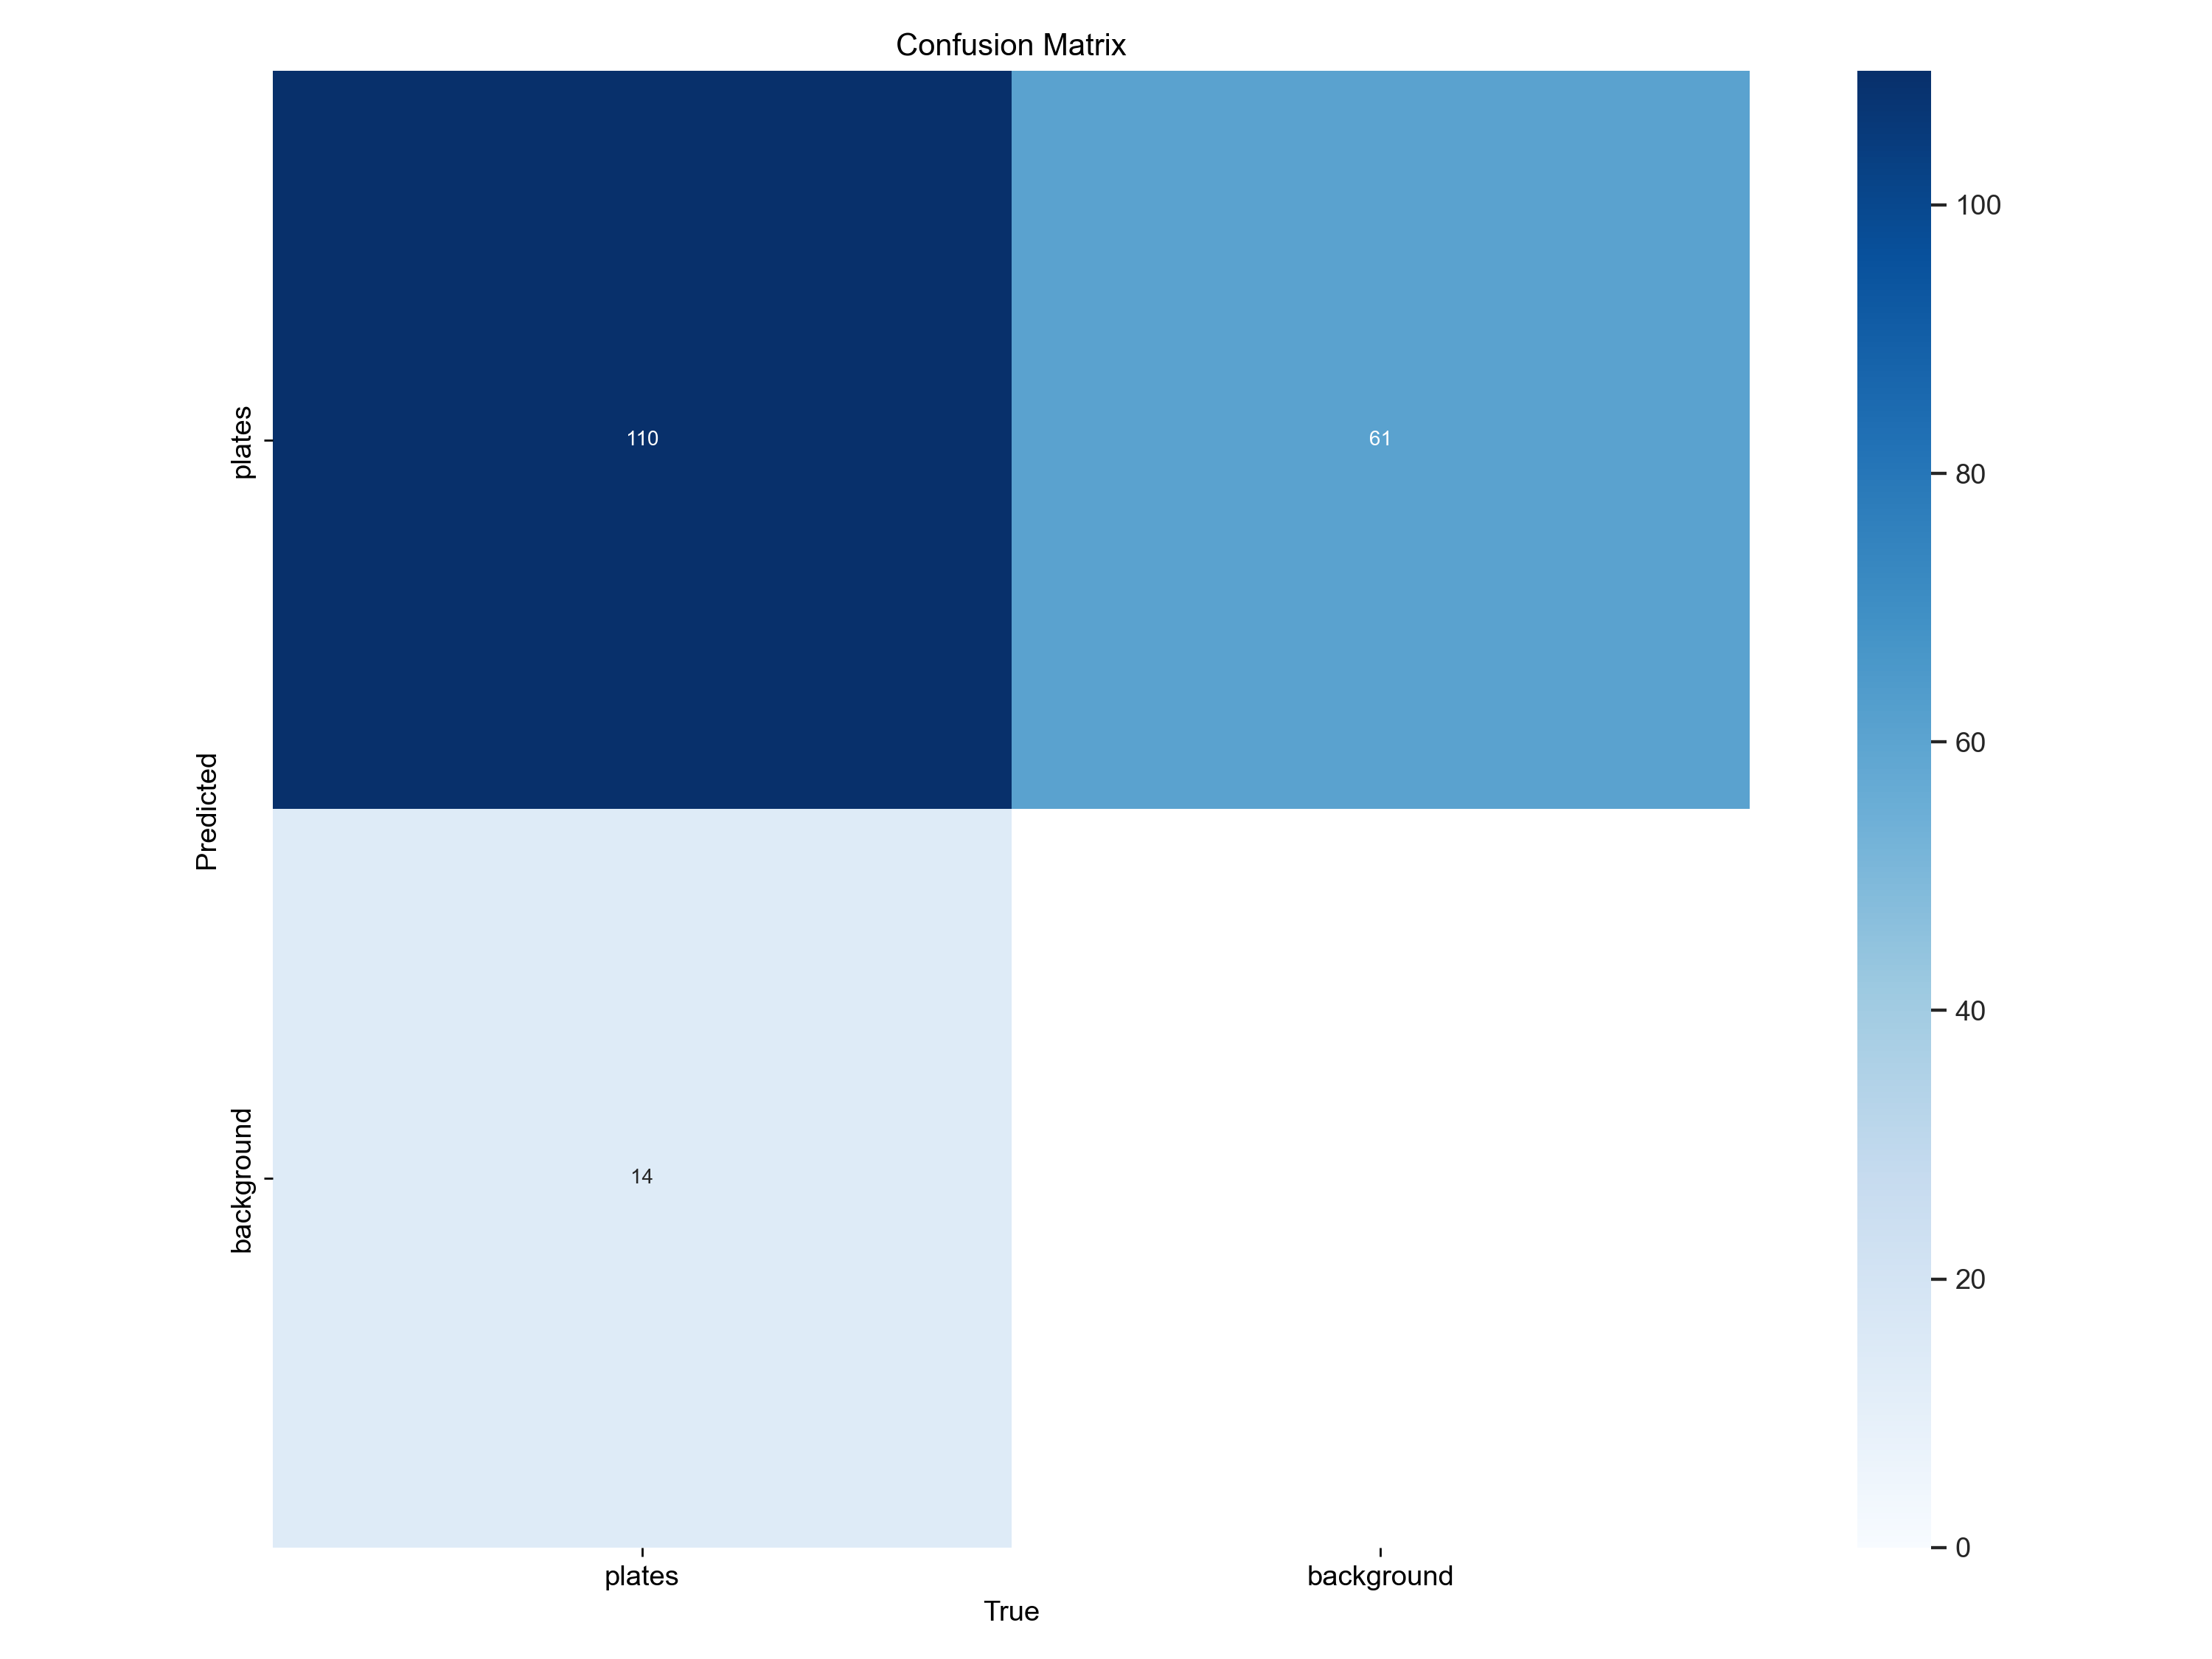

In [14]:
Image(filename=f'{HOME}/train/runs/detect/train/confusion_matrix.png', width=1000)

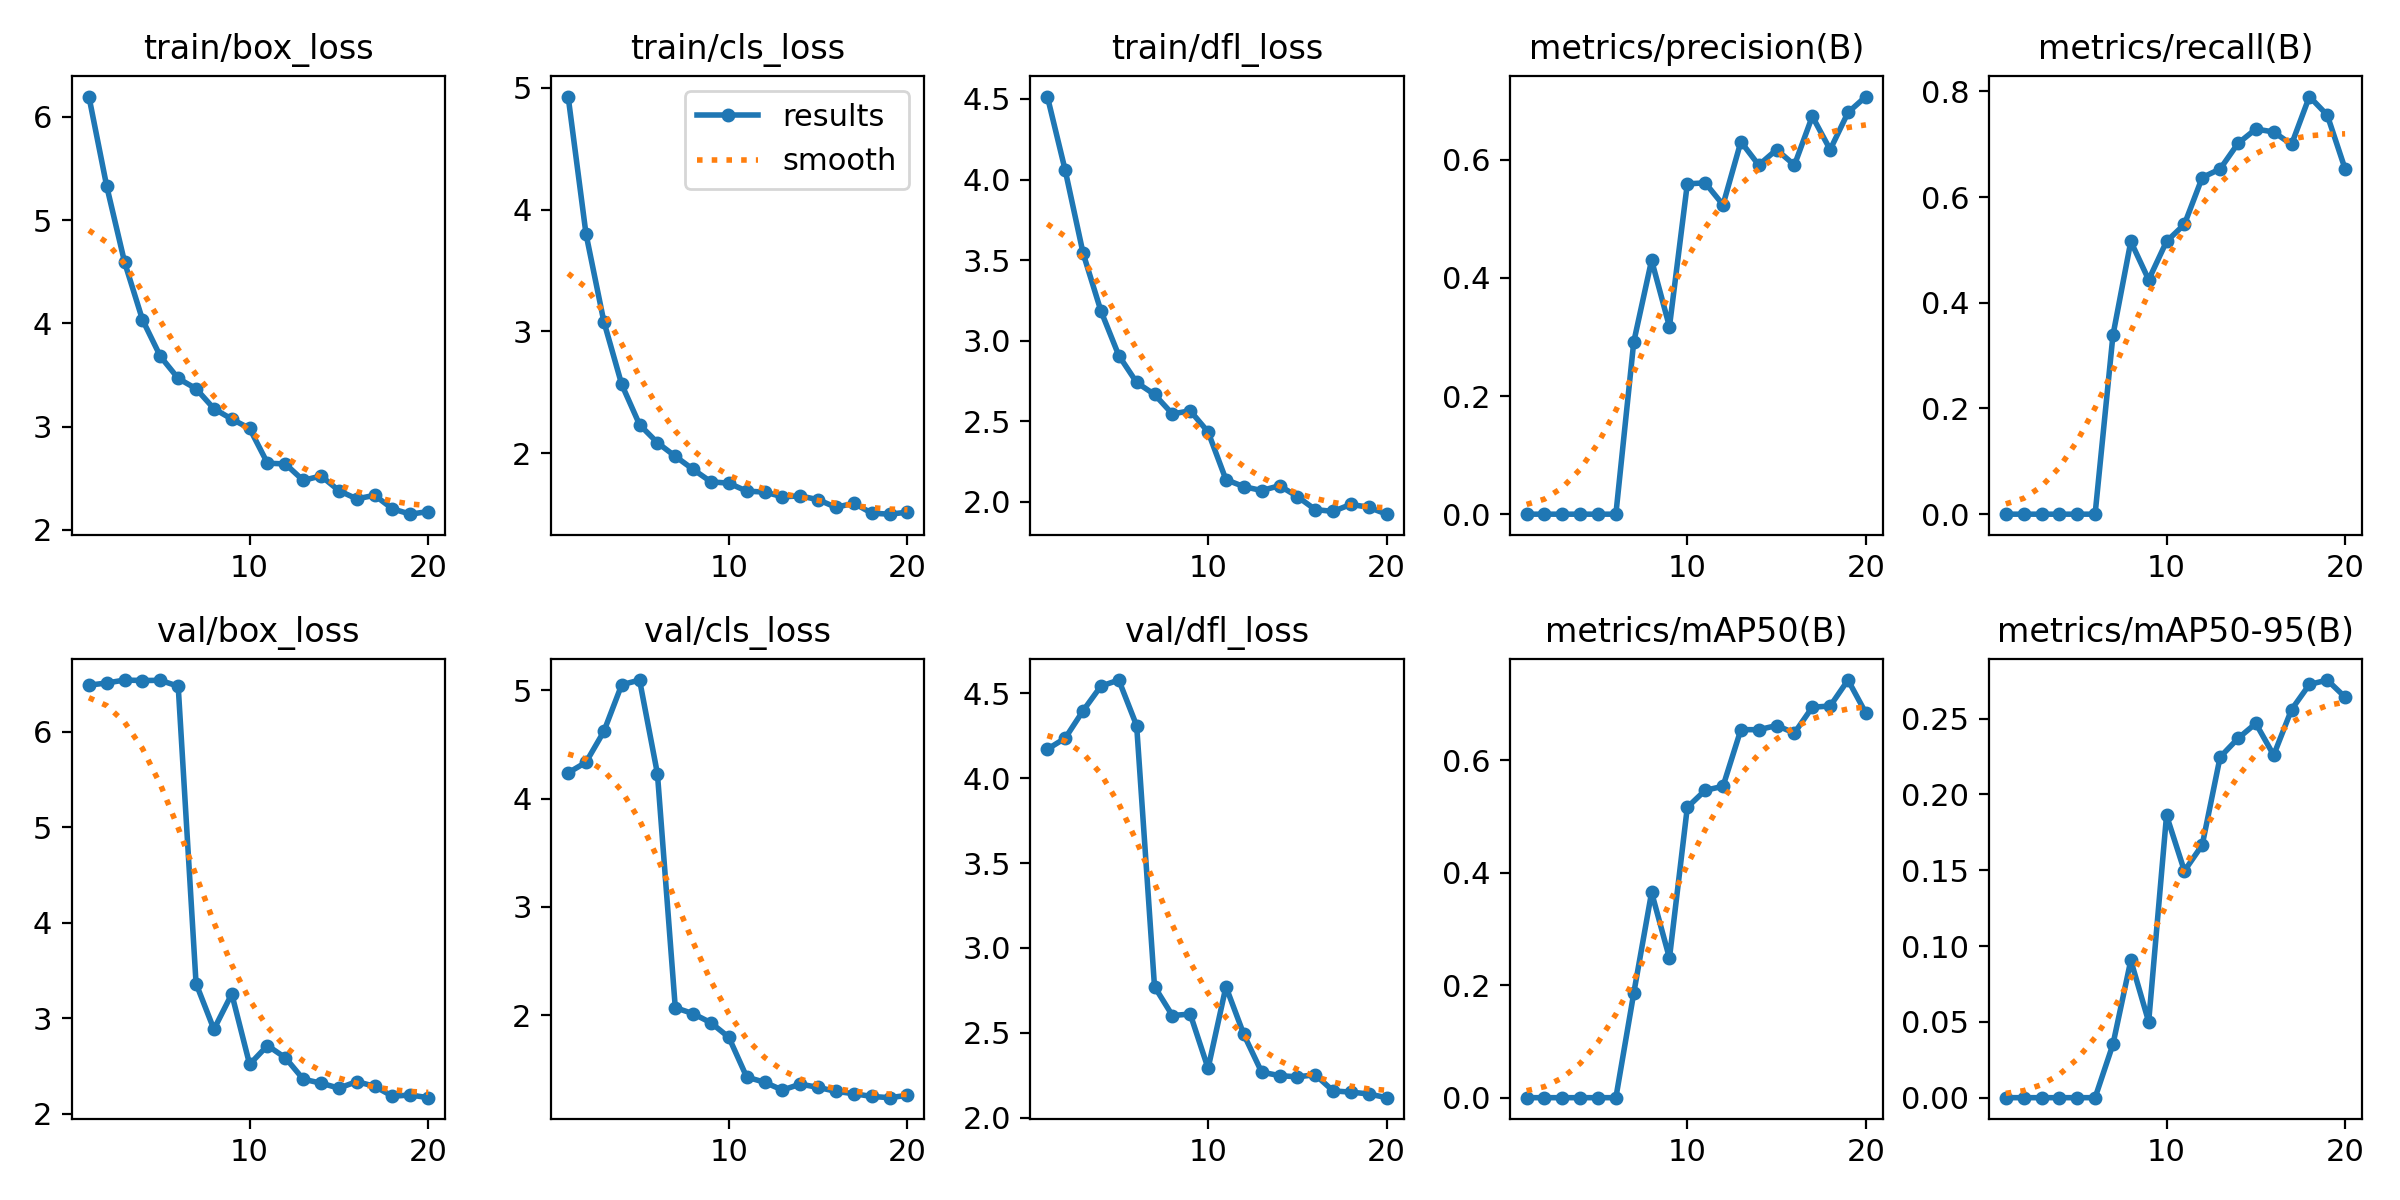

In [18]:
Image(filename=f'{HOME}/train/runs/detect/train/results.png', width=1000)

In [20]:
import supervision as sv

ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/test/images",
    annotations_directory_path=f"{dataset_location}/test/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

ds.classes

['plates']

In [32]:
from supervision.metrics import MeanAveragePrecision

model = YOLO('runs/detect/train/weights/best.pt')

predictions = []
targets = []

for _, image, target in ds:
    results = model(image, verbose=False)[0]
    detections = sv.Detections.from_ultralytics(results)

    predictions.append(detections)
    targets.append(target)

map = MeanAveragePrecision().update(predictions, targets).compute()

In [33]:
print("mAP 50:95", map.map50_95)
print("mAP 50", map.map50)
print("mAP 75", map.map75)

mAP 50:95 0.26758188008964817
mAP 50 0.7968064277948805
mAP 75 0.11720176584538655


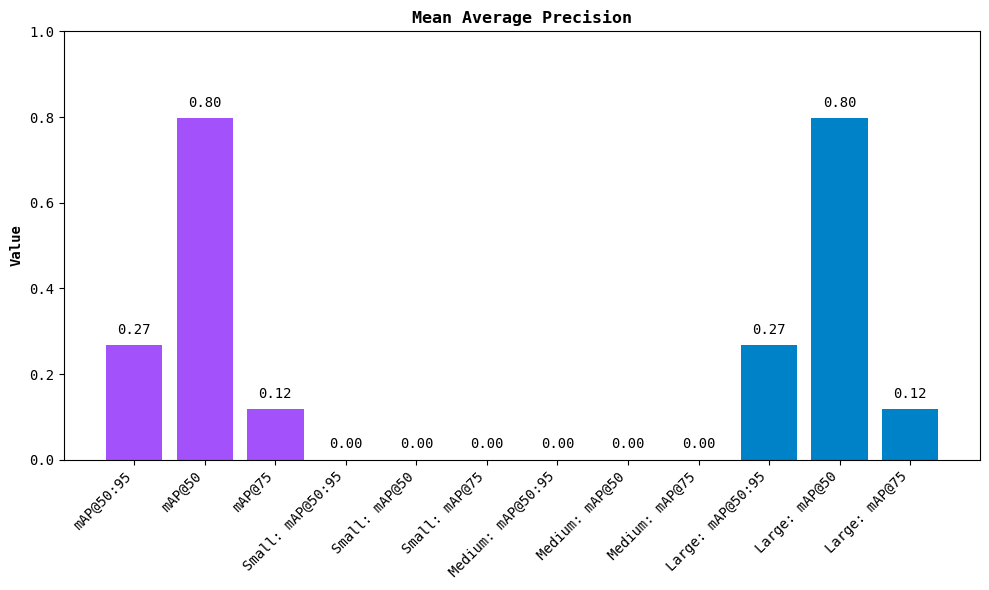

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt

map.plot()
plt.show()


## Run inference with fine-tuned YOLOv12 model

In [48]:

from PIL import Image, ImageOps
model = YOLO('runs/detect/train/weights/best.pt')
ds = sv.DetectionDataset.from_yolo(
    images_directory_path=f"{dataset_location}/test/images",
    annotations_directory_path=f"{dataset_location}/test/labels",
    data_yaml_path=f"{dataset_location}/data.yaml"
)

In [41]:
def histogram_equalization(image):
    """
    ทำ Histogram Equalization บนช่อง Value (V) ของภาพ HSV
    """
    # แปลงจาก RGB เป็น HSV
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

    # แยกช่อง Hue, Saturation, Value
    h, s, v = cv2.split(hsv)

    # ทำ Histogram Equalization บนช่อง V (ความสว่าง)
    v_eq = cv2.equalizeHist(v)

    # รวมกลับเป็น HSV
    hsv_eq = cv2.merge([h, s, v_eq])
    # แปลงกลับเป็น RGB
    image_eq = cv2.cvtColor(hsv_eq, cv2.COLOR_HSV2RGB)

    return image_eq

def white_balance_simple(image):
    """
    Simple white balance by scaling channels based on average intensity
    """
    # Convert to float for calculations
    image_float = image.astype(np.float32)

    # Calculate the mean for each channel
    mean_r = np.mean(image_float[:,:,0])
    mean_g = np.mean(image_float[:,:,1])
    mean_b = np.mean(image_float[:,:,2])

    # Calculate scaling factors
    scale_r = 128 / mean_r if mean_r > 0 else 1
    scale_g = 128 / mean_g if mean_g > 0 else 1
    scale_b = 128 / mean_b if mean_b > 0 else 1

    # Scale each channel
    image_float[:,:,0] *= scale_r
    image_float[:,:,1] *= scale_g
    image_float[:,:,2] *= scale_b

    # Clip values to valid range
    image_balanced = np.clip(image_float, 0, 255).astype(np.uint8)

    return image_balanced

def white_balance_gray_world(image):
    """
    Gray World Assumption white balance method
    """
    # Convert to float for calculations
    image_float = image.astype(np.float32)

    # Calculate average of each channel
    r_avg = np.mean(image_float[:,:,0])
    g_avg = np.mean(image_float[:,:,1])
    b_avg = np.mean(image_float[:,:,2])

    # Calculate the overall average
    avg = (r_avg + g_avg + b_avg) / 3

    # Calculate scaling factors
    r_scale = avg / r_avg if r_avg > 0 else 1
    g_scale = avg / g_avg if g_avg > 0 else 1
    b_scale = avg / b_avg if b_avg > 0 else 1

    # Apply scaling
    image_float[:,:,0] *= r_scale
    image_float[:,:,1] *= g_scale
    image_float[:,:,2] *= b_scale

    # Clip values to valid range
    image_balanced = np.clip(image_float, 0, 255).astype(np.uint8)
    return image_balanced

In [42]:
def detect_color_from_bbox(image, bbox, crop_ratio=0.8):
    """
    Detect average color from bounding box using advanced color analysis

    Args:
    - image: PIL Image
    - bbox: (xmin, ymin, xmax, ymax)
    - crop_ratio: Ratio of bounding box to analyze (default 0.8)

    Returns:
    - Tuple of (hue, saturation, value)
    """
    xmin, ymin, xmax, ymax = bbox
    cropped_img = image.crop((xmin, ymin, xmax, ymax))
    cropped_img = np.array(cropped_img)

    # Convert to HSV
    hsv_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2HSV)

    # Apply median blur to reduce noise
    hsv_img = cv2.medianBlur(hsv_img, 5)

    # Crop center of the image
    h, w, _ = hsv_img.shape
    new_h, new_w = int(h * crop_ratio), int(w * crop_ratio)
    y_offset, x_offset = (h - new_h) // 2, (w - new_w) // 2
    cropped_center = hsv_img[y_offset:y_offset+new_h, x_offset:x_offset+new_w]

    # Calculate median values
    avg_hue = np.median(cropped_center[:, :, 0])
    avg_sat = np.median(cropped_center[:, :, 1])
    avg_val = np.median(cropped_center[:, :, 2])

    return avg_hue, avg_sat, avg_val

def identify_color(avg_hue, avg_sat, avg_val):
    """
    Identify color based on HSV values

    Args:
    - avg_hue: Hue value (0-180 in OpenCV)
    - avg_sat: Saturation value (0-255)
    - avg_val: Value/Brightness value (0-255)

    Returns:
    - Color name as string
    """
    # Convert OpenCV HSV to standard HSV
    hue = avg_hue * 2  # OpenCV uses 0-180, standard HSV uses 0-360
    sat = avg_sat / 255 * 100  # Convert to percentage
    val = avg_val / 255 * 100  # Convert to percentage

    # Print debug information
    print(f"🔍 Hue: {hue:.2f}, Saturation: {sat:.2f}%, Value: {val:.2f}%")

    # Check for white, black, or gray conditions
    if val < 20:
        return "Black"
    if sat < 20 or val > 90:
        return "White"

    # Detailed color mapping
    if (hue >= 330 or hue <= 30):  # Red
        return "Red"
    elif 30 < hue < 90:  # Yellow to Green
        if hue < 60:
            return "Yellow"
        else:
            return "Green"
    elif 90 <= hue < 150:  # Cyan to Blue
        if hue < 120:
            return "Cyan"
        else:
            return "Blue"
    elif 150 <= hue < 270:  # Blue to Purple
        if hue < 210:
            return "Blue"
        else:
            return "Purple"
    elif 270 <= hue < 330:  # Magenta to Red
        return "Red2"

    return "Unknown"

In [64]:
# Main processing function
def process_image(image_path, model, sv):
    # Open and preprocess image
    image = Image.open(image_path)
    image = ImageOps.exif_transpose(image)
    image = image.convert("RGB")
    image = Image.fromarray(white_balance_gray_world(np.array(image)))

    # Detect objects
    results = model(image, verbose=False)[0]
    # ปรับค่า IoU threshold ในขั้นตอน NMS
    detections = sv.Detections.from_ultralytics(results).with_nms()


    # Annotate image
    box_annotator = sv.BoxAnnotator(thickness=5)
    label_annotator = sv.LabelAnnotator()
    annotated_image = image.copy()
    annotated_image = box_annotator.annotate(scene=annotated_image, detections=detections)
    annotated_image = label_annotator.annotate(scene=annotated_image, detections=detections)

    # Count colors
    dict_count = {}
    for i, box in enumerate(detections.xyxy):
        avg_color = detect_color_from_bbox(image, box)
        color = identify_color(*avg_color)

        # Count colors
        dict_count[color] = dict_count.get(color, 0) + 1

    # Print results
    for key, value in dict_count.items():
        print(f"{key}: {value}")

    print(f"Number of detections: {len(detections.xyxy)}")
    print(f"Number of boxes drawn: {len(detections)}")

    # Plot image
    sv.plot_image(annotated_image)

    return dict_count, annotated_image

# Call the processing function

# result_count, result_image = process_image(image_path, model, sv)

## predict your picture

🔍 Hue: 198.00, Saturation: 12.55%, Value: 51.37%
🔍 Hue: 356.00, Saturation: 81.96%, Value: 35.29%
🔍 Hue: 170.00, Saturation: 5.88%, Value: 48.63%
🔍 Hue: 150.00, Saturation: 5.49%, Value: 41.57%
🔍 Hue: 356.00, Saturation: 50.98%, Value: 75.29%
🔍 Hue: 196.00, Saturation: 12.55%, Value: 95.29%
🔍 Hue: 346.00, Saturation: 78.04%, Value: 29.80%
White: 4
Red: 3
Number of detections: 7
Number of boxes drawn: 7


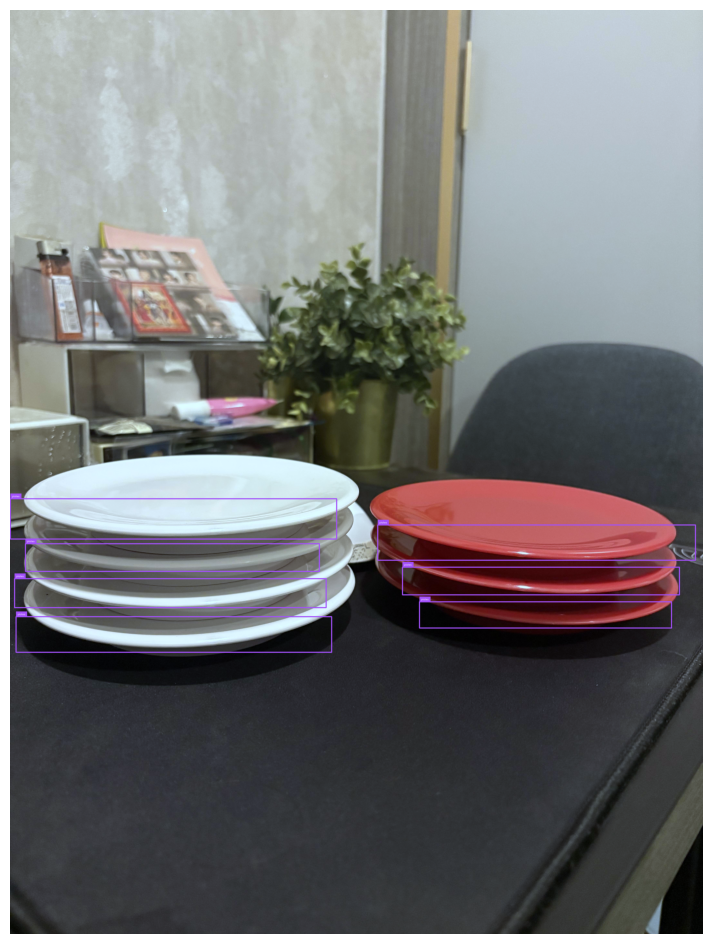

In [65]:
#select your picture to predict
image_path = "c:\\Manus\\DL_project\\project\\3.jpg"
result_count, result_image = process_image(image_path, model, sv)

## predict dataset test

🔍 Hue: 354.00, Saturation: 96.08%, Value: 11.76%
🔍 Hue: 346.00, Saturation: 58.04%, Value: 22.75%
🔍 Hue: 200.00, Saturation: 21.96%, Value: 83.53%
🔍 Hue: 348.00, Saturation: 36.47%, Value: 21.18%
🔍 Hue: 352.00, Saturation: 94.90%, Value: 11.37%
🔍 Hue: 290.00, Saturation: 37.06%, Value: 20.78%
🔍 Hue: 350.00, Saturation: 55.29%, Value: 58.82%
🔍 Hue: 354.00, Saturation: 96.08%, Value: 12.55%
🔍 Hue: 354.00, Saturation: 93.73%, Value: 12.55%
🔍 Hue: 354.00, Saturation: 95.29%, Value: 18.43%
🔍 Hue: 354.00, Saturation: 94.12%, Value: 13.33%
🔍 Hue: 246.00, Saturation: 20.00%, Value: 37.84%
🔍 Hue: 354.00, Saturation: 57.25%, Value: 61.18%
🔍 Hue: 22.00, Saturation: 9.80%, Value: 36.08%
🔍 Hue: 222.00, Saturation: 29.02%, Value: 23.53%
🔍 Hue: 264.00, Saturation: 25.49%, Value: 21.96%
🔍 Hue: 348.00, Saturation: 57.25%, Value: 24.31%
🔍 Hue: 206.00, Saturation: 30.98%, Value: 48.63%
Black: 6
Red: 5
Blue: 2
Red2: 1
Purple: 3
White: 1
Number of detections: 18
Number of boxes drawn: 18


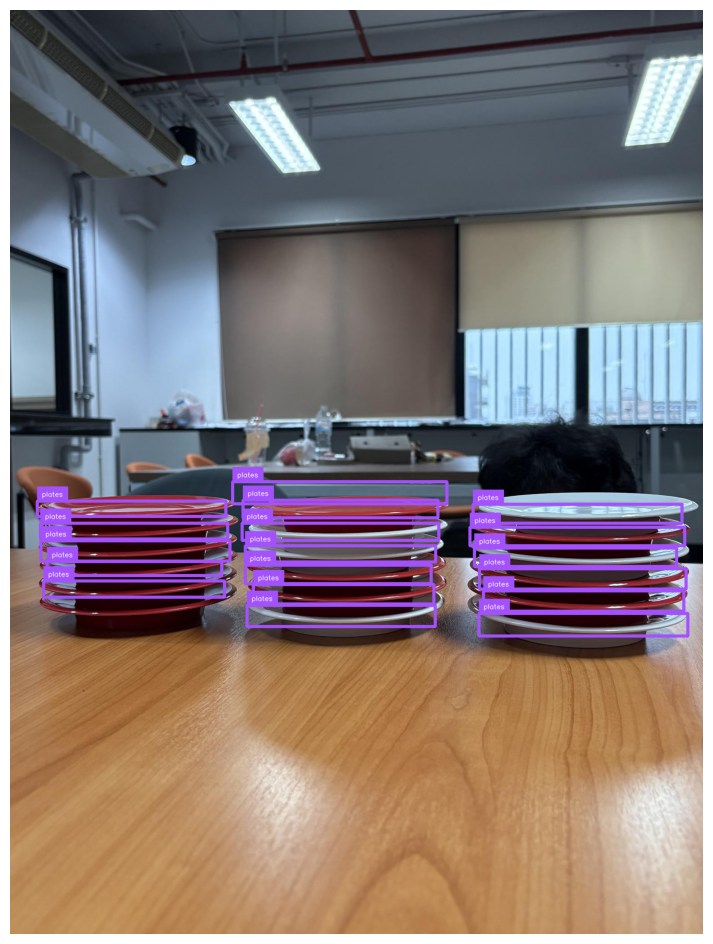

In [59]:
i = random.randint(0, len(ds))

image_path, image, target = ds[i]

result_count, result_image = process_image(image_path, model, sv)